This is part of HW 4. We have done following thing.

1. Residual Connection is used.
2. Trained for L = 32 and 50K examples
3. Evaluated for CL = [16,32,64,128]
4. M = 1 and Tau = 1
5. Batch Size =64


In [2]:
#pip install rotary-embedding-torch

In [3]:
#pip install mamba-ssm

In [3]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from rotary_embedding_torch import RotaryEmbedding
from mamba_ssm import Mamba
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
from mamba_ssm.models.config_mamba import MambaConfig
from mamba_ssm.modules.mamba_simple import Mamba, Block as Mamba_block
from mamba_ssm.utils.generation import GenerationMixin
from mamba_ssm.utils.hf import load_config_hf, load_state_dict_hf
from functools import partial
from mamba_ssm.ops.triton.layernorm import RMSNorm, layer_norm_fn, rms_norm_fn

We are giving you a 2 layer transformer model in induction task. Check the data generation mechanism for the induction head and adjust it accordingly to your needs. For AR, you need to code one from scratch.

In [5]:
class InductionAR(Dataset):

    # In induction head we have ngram = 1. But the code provided is for general ngram setting. While using this, initialize ngram = 1.
    """ Naive associative recall dataset """
    def __init__(self, num_examples, tokenizer, n_gram=1, n_ctx = 1024, seed = 0, train_split=0.8, tau = 1, M = 1):
        self.num_examples = num_examples
        self.tokenizer = tokenizer
        self.n_ctx = n_ctx
        self.seed = seed
        self.n_gram = n_gram
        self.tau = tau
        self.M = M
        x, y = self.data_gen()
        if train_split:
            self.train_x, self.train_y, self.test_x, self.test_y = self.split(x, y, train_split)
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = self.numpy_to_tensor_dataset(self.test_x, self.test_y)
        else:
            self.train_x, self.train_y, self.test_x, self.test_y = x, y, None, None
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = None
    def get_str_dataset(self, split="train"):
        if split == "train":
            x_str = [self.tokenizer.decode(xi) for xi in self.train_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.train_y]
        elif split == "test":
            x_str = [self.tokenizer.decode(xi) for xi in self.test_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.test_y]
        else:
            raise ValueError("split should be either 'train' or 'test'")
        return x_str, y_str
    def numpy_to_tensor_dataset(self, x, y):
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return TensorDataset(x, y)
    def gen_single_example(self):
        # get the vocab size
        def count(str_x, str_n_gram_head):
            counts = sum([
                str_x.startswith(str_n_gram_head, i) for i in range(len(str_x))
            ])
            return counts
        def gen_x():
            gen_x_success = False
            while not gen_x_success:
                x = np.random.choice(vocab[self.M:], self.n_ctx-self.n_gram*2, replace=True).tolist()
                # remove the case where the n_gram_head is repeated in the sequence
                for _ in range(10):
                    pos = [i for i in range(len(x)-len(n_gram_head)+1) if x[i:i+len(n_gram_head)] == n_gram_head]
                    if len(pos) == 0:
                        gen_x_success = True
                        break
                    else:
                        # remove the n_gram_head from x
                        # get all positions of the n_gram_head in x
                        for p in reversed(pos):
                            # remove len(n_gram_head) elements from x starting from p
                            x = x[:p] + x[p+len(n_gram_head):]
                        # fill the rest of the sequence with random elements
                        x.extend(np.random.choice(vocab[self.M:], self.n_ctx-self.n_gram*2-len(x), replace=True).tolist())
                x_test = " ".join([str(xi) for xi in x])
                if count(x_test, str_n_gram_head) == 0:
                    gen_x_success = True

            x_test = x + n_gram_head
            # check if there's only one n_gram_head in the sequence
            # to avoid the case where the n_gram_head has
            # repeated structure such as x= [1, 2, 3, 1] , n_gram_head = [1, 1]
            str_x_test = " "+" ".join([str(xi) for xi in x_test])+ " "
            if count(str_x_test, str_n_gram_head) > 1:
                print("Error in gen_x")
                print(f"str_x_test: {str_x_test}", f"str_n_gram_head: {str_n_gram_head}",
                      "count: ", count(str_x_test, str_n_gram_head))
            if count(str_x_test, str_n_gram_head) == 1:
                return x
            else:
                return None
        def insert_n_gram_head(x):
            #pos = random.randint(0, len(x)-1)
            pos = random.randint(0, len(x)- self.tau- 1)
            pos_delay = pos + self.tau
            #y = x[pos]
            y = x[pos_delay]
            x_new = x[:pos] + n_gram_head + x[pos:] + n_gram_head
            str_x_new = " "+" ".join([str(xi) for xi in x_new])+" "

            if count(str_x_new, str_n_gram_head) == 2:
                return x_new, y
            else:
                return None, None
        vocab_size = len(self.tokenizer)
        vocab = list(range(vocab_size))
        # set a deterministic n_gram_head
        #n_gram_head = list(range(self.n_gram))
        n_gram_head = [random.choice(vocab[:self.M])]

        str_n_gram_head = " "+" ".join([str(xi) for xi in n_gram_head])+" "
        assert self.n_gram*2 < self.n_ctx, "n_gram*2 should be less than n_ctx"
        success = False
        while not success:
            x = gen_x()
            if x is not None:
                for _ in range(10):
                    x_new, y = insert_n_gram_head(x)
                    if x_new is not None:
                        success = True
                        break
        return x_new, y

    def data_gen(self):
        x = []
        y = []
        # get previous random status and recover after generating the dataset
        random_status = random.getstate()
        random.seed(self.seed)
        for i in range(self.num_examples):
            #if i % 1000 == 0:
            #    print(f"Generating example {i}")
            xi, yi = self.gen_single_example()
            x.append(xi)
            y.append(yi)
        x = np.array(x)
        y = np.array(y)
        random.setstate(random_status)
        return x, y
    def split(self, x, y, train_ratio = 0.8):
        num_train = int(len(x)*train_ratio)
        train_x = x[:num_train]
        train_y = y[:num_train]
        test_x = x[num_train:]
        test_y = y[num_train:]
        return train_x, train_y, test_x, test_y


In [6]:

class Random_tokenizer:
    def __init__(self, vocab=None, vocab_size = None) -> None:
        """ The init function of the tokenizer class.
         one of vocab or vocab_size should be provided.
         If vocab is provided, vocab_size will be ignored.
         If vocab is not provided, vocab_size should be provided. we will generate a random vocab of vocab_size."""
        if vocab is not None:
            self.vocab = vocab
            self.vocab_size = len(vocab)
        elif vocab_size is not None:
            self.vocab_size = vocab_size
            self.vocab = [str(i) for i in range(vocab_size)]
        else:
            raise ValueError("one of vocab or vocab_size should be provided.")
        self.vocab_dict = {v: i for i, v in enumerate(self.vocab)}
        self.vocab_dict_inv = {i: v for i, v in enumerate(self.vocab)}
    def encode(self, x):
        """ Encode a string into a list of integers """
        return [self.vocab_dict[i] for i in x]
    def decode(self, x):
        """ Decode a list of integers into a string """
        return ' '.join([self.vocab_dict_inv[i] for i in x])
    def __len__(self):
        return self.vocab_size
    def __getitem__(self, i):
        return self.vocab[i]
    def __iter__(self):
        return iter(self.vocab)
    def __contains__(self, x):
        return x in self.vocab
    def __repr__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __str__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __call__(self, x):
        return self.encode(x)


Transformer with PE

In [7]:
def apply_rotary_pos_emb(q, k, rotary_emb, seq_dim=-2):
    q = rotary_emb.rotate_queries_or_keys(q, seq_dim=seq_dim)
    k = rotary_emb.rotate_queries_or_keys(k, seq_dim=seq_dim)
    return q, k


class Block(nn.Module):
    def __init__(self, embed_dim, max_len=11, pos_encoding=None):
        super(Block, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.c_attn = nn.Linear(embed_dim, embed_dim*3)
        self.register_buffer('mask', torch.tril(torch.ones(max_len, max_len)))
        self.pos_encoding = pos_encoding
        if self.pos_encoding == 'RoPE':
            self.rotary_emb = RotaryEmbedding(dim=embed_dim)

    def forward(self, x):
        T = x.size(1)
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        if self.pos_encoding == 'RoPE':
            q, k = apply_rotary_pos_emb(q, k, self.rotary_emb, seq_dim=-2)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal = True)
        return y


In [8]:

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


class BaseNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, pos_encoding='LearnedPE', max_len=11, attn_layers=2, block=Block):
        super(BaseNet, self).__init__()
        if block is None:
            raise ValueError("block type should be provided.")
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pe = nn.Embedding(max_len, embed_dim) if pos_encoding == 'LearnedPE' else None
        self.att = nn.ModuleList([block(embed_dim, max_len, pos_encoding=pos_encoding) for _ in range(attn_layers)])
        self.ln = nn.ModuleList([LayerNorm(embed_dim, True) for _ in range(attn_layers)])
        self.head = nn.Linear(embed_dim, vocab_size)

        print(f"BaseNet with {attn_layers} layers of {block.__name__} blocks")
        print(f"Embedding dimension: {embed_dim}")
        print(f"Positional Encoding: {pos_encoding}")  # Changed from is_pe to pos_encoding
        print(f"Vocabulary size: {vocab_size}")
        print(f"Context length: {max_len}")

    def forward(self, x):
        b, t = x.size()
        x = self.embed(x)
        if self.pe is not None:
            pos = torch.arange(0, t, dtype=torch.long, device=x.device)
            pe_emb = self.pe(pos)
            x += pe_emb
        for layer, ln in zip(self.att, self.ln):
            residual = x  # Save the input to the layer
            x = layer(x)
            x = residual + x  # Add the residual connection
            x = ln(x)  # Apply layer normalization
        x = self.head(x)
        return x



In [9]:
class ExtendedBlock(Mamba_block):
    def __init__(self, embed_dim, mixer_cls, norm_cls, residual_in_fp32, max_len):
        super().__init__(embed_dim, mixer_cls, norm_cls=norm_cls, residual_in_fp32=residual_in_fp32)
        self.register_buffer('mask', torch.tril(torch.ones(max_len, max_len)))

def create_block(embed_dim, max_len=11, norm_epsilon=1e-5, rms_norm=False, residual_in_fp32=False, layer_idx=None, device=None, dtype=None):
    mixer_cls = partial(Mamba, layer_idx=layer_idx)
    norm_cls = nn.LayerNorm  # Assuming no need for customization based on rms_norm in your code snippet

    # Create instance of ExtendedBlock instead of Block
    block = ExtendedBlock(
        embed_dim,
        mixer_cls,
        norm_cls=norm_cls,
        residual_in_fp32=residual_in_fp32,
        max_len=max_len
    )
    block.layer_idx = layer_idx

    if device is not None:
        block.to(device)
    if dtype is not None:
        block.to(dtype)

    return block



class MixerModel(nn.Module):
  def __init__(
        self,
        embed_dim: int,
        max_len: int,
        n_layer: int,
        vocab_size: int,
        norm_epsilon: float = 1e-5,
        residual_in_fp32=False,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__()
        self.residual_in_fp32 = residual_in_fp32

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList(
            [
                create_block(
                    embed_dim,
                    max_len=max_len,  # Pass max_len from constructor
                    norm_epsilon=norm_epsilon,
                    residual_in_fp32=residual_in_fp32,
                    layer_idx=i
                )
                for i in range(n_layer)
            ]
        )

        self.norm_f = nn.LayerNorm(embed_dim, eps=norm_epsilon)
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)

  def forward(self, x, inference_params=None):
      x = self.embedding(x)
      residual = None
      for layer in self.layers:
          x, residual = layer(
              x, residual, inference_params=inference_params
          )

      # Always perform the addition and normalization separately
      residual = (x + residual) if residual is not None else x
      x = self.norm_f(residual.to(dtype=self.norm_f.weight.dtype))

      return self.lm_head(x)



In [10]:
class MixerModelHybrid(nn.Module):
  def __init__(
        self,
        embed_dim: int,
        max_len: int,
        n_layer: int,
        vocab_size: int,
        norm_epsilon: float = 1e-5,
        residual_in_fp32=False,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__()
        self.residual_in_fp32 = residual_in_fp32

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList()

        for i in range(n_layer):
            if i % 2 == 0:  # Even index, Mamba layer
                self.layers.append(create_block(
                    embed_dim,
                    max_len=max_len,  # Pass max_len from constructor
                    norm_epsilon=norm_epsilon,
                    residual_in_fp32=residual_in_fp32,
                    layer_idx=i
                ))
            else:  # Odd index, Attention layer
                self.layers.append(Block(embed_dim, max_len, pos_encoding=None))

        self.norm_f = nn.LayerNorm(embed_dim, eps=norm_epsilon)
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)

  def forward(self, x, inference_params=None):
    x = self.embedding(x)
    residual = None
    for idx, layer in enumerate(self.layers):
        if idx % 2 == 0:  # Mamba layer
            # Process Mamba layer which outputs transformed x and a new_residual
            x, new_residual = layer(x, residual, inference_params=inference_params)
            if residual is not None:
                x = x + residual  # Add old residual to the output before updating it
            residual = new_residual  # Update residual for the next layer
        else:  # Attention layer
            saved_x = x  # Save the input to the layer
            x = layer(x)  # Process through the attention layer
            x = x + saved_x  # Add the residual after processing

        x = self.norm_f(x)  # Apply normalization after each layer

    return self.lm_head(x)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
seed = 0
torch.manual_seed(seed)

# Training configuration
n_ctx = 32
num_examples = 50000
batch_size = 64
vocab_size = 16
num_epochs = 500
embed_dim = 8
attn_layers = 2 # number of attention layers
mamba_layers = 2
report_frequency = 10  # Record accuracy every 10 batches

# Tokenizer and data
tokenizer = Random_tokenizer(vocab_size=vocab_size)
dataset = InductionAR(num_examples, tokenizer, 1, n_ctx=n_ctx, seed=seed, train_split=0.8, tau = 1, M = 1)
train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)



Using cuda device


In [12]:
models = [
    BaseNet(len(tokenizer), embed_dim=embed_dim, pos_encoding='LearnedPE', max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device),
    BaseNet(len(tokenizer), embed_dim=embed_dim, pos_encoding='RoPE', max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device),
    BaseNet(len(tokenizer), embed_dim=embed_dim, pos_encoding=None, max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device),
    MixerModel(embed_dim=embed_dim, max_len=n_ctx*4, n_layer=mamba_layers, vocab_size=len(tokenizer)).to(device),
    MixerModelHybrid(embed_dim=embed_dim, max_len=n_ctx*4, n_layer=mamba_layers, vocab_size=len(tokenizer)).to(device),
    MixerModelHybrid(embed_dim=embed_dim, max_len=n_ctx*4, n_layer=mamba_layers+1, vocab_size=len(tokenizer)).to(device)
]

# Prepare structures to hold training data
model_losses = {i: [] for i in range(len(models))}
model_accuracies_per_iteration = {i: [] for i in range(len(models))}
consecutive_max_accuracy = {i: 0 for i in range(len(models))}  # To track consecutive epochs of maximum accuracy

# Function to compute AR accuracy
def calculate_ar_accuracy(model, loader):
    model.eval()  # Ensure the model is in evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = torch.argmax(F.softmax(y_pred, dim=-1), dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
    model.train()  # Switch back to training mode
    return correct / total

record_frequency = 20  # Frequency to record and report losses

for index, model in enumerate(models):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)
    has_terminated_early = False  # Flag to determine if training was terminated early

    for epoch in range(num_epochs):
        if epoch == 340:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.001
        epoch_losses = []
        epoch_accuracies = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)[:,-1]
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        if (epoch + 1) % record_frequency == 0:
            epoch_loss = sum(epoch_losses) / len(train_loader)
            accuracy = calculate_ar_accuracy(model, test_loader)
            model_losses[index].append(epoch_loss)
            model_accuracies_per_iteration[index].append(accuracy)
            print(f'Model {index}, Epoch {epoch+1}: Loss = {epoch_loss:.8f}, Accuracy = {accuracy:.8f}')

            if accuracy == 1.0:
                consecutive_max_accuracy[index] += 1
            else:
                consecutive_max_accuracy[index] = 0

            if consecutive_max_accuracy[index] >= 2:
                print(f"Model {index} training terminated early due to high accuracy.")
                has_terminated_early = True
                break

        if has_terminated_early:
            break



BaseNet with 2 layers of Block blocks
Embedding dimension: 8
Positional Encoding: LearnedPE
Vocabulary size: 16
Context length: 128
BaseNet with 2 layers of Block blocks
Embedding dimension: 8
Positional Encoding: RoPE
Vocabulary size: 16
Context length: 128
BaseNet with 2 layers of Block blocks
Embedding dimension: 8
Positional Encoding: None
Vocabulary size: 16
Context length: 128
Model 0, Epoch 20: Loss = 2.61109677, Accuracy = 0.13230000
Model 0, Epoch 40: Loss = 0.54948061, Accuracy = 0.85080000
Model 0, Epoch 60: Loss = 0.29115674, Accuracy = 0.87580000
Model 0, Epoch 80: Loss = 0.20398359, Accuracy = 0.91910000
Model 0, Epoch 100: Loss = 0.08464654, Accuracy = 0.95010000
Model 0, Epoch 120: Loss = 0.06040585, Accuracy = 0.97450000
Model 0, Epoch 140: Loss = 0.04126734, Accuracy = 0.98310000
Model 0, Epoch 160: Loss = 0.03448914, Accuracy = 0.98620000
Model 0, Epoch 180: Loss = 0.00655633, Accuracy = 0.99700000
Model 0, Epoch 200: Loss = 0.00001058, Accuracy = 1.00000000
Model 0,

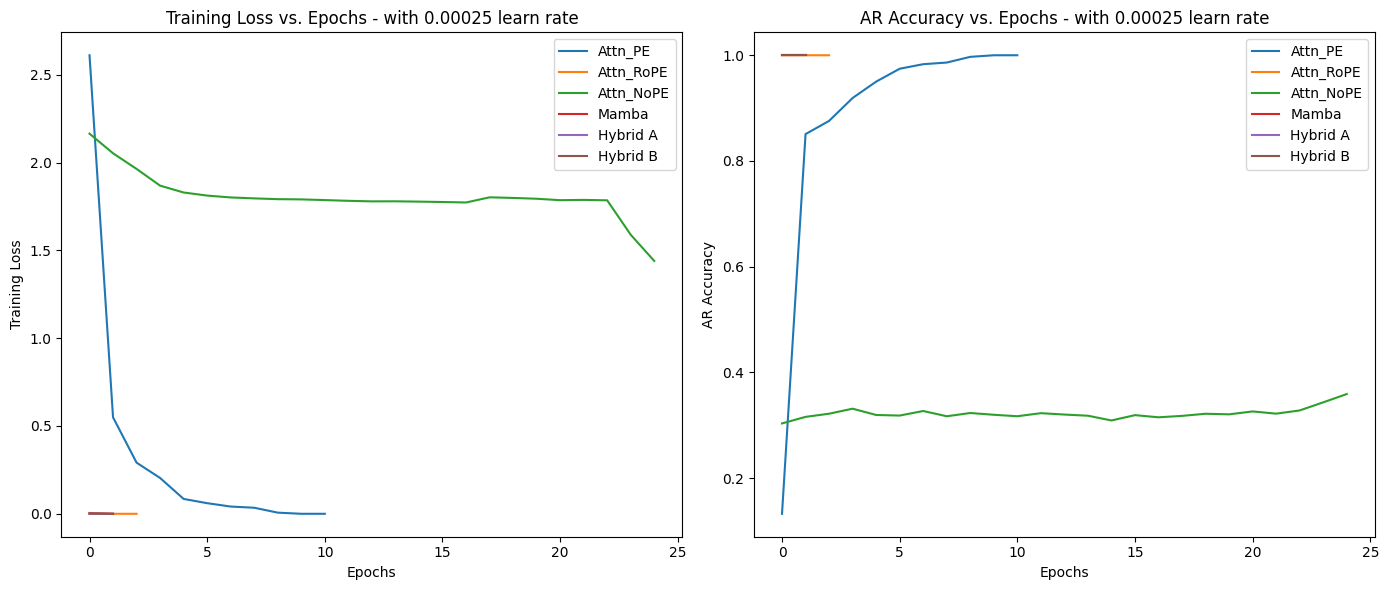

In [13]:
# Plotting results
plt.figure(figsize=(14, 6))
model_names = {
    0: 'Attn_PE',
    1: 'Attn_RoPE',
    2: 'Attn_NoPE',
    3: 'Mamba',
    4: 'Hybrid A',
    5: 'Hybrid B'
}

# Plot training losses
plt.subplot(1, 2, 1)
for index, losses in model_losses.items():
    plt.plot(range(len(losses)), losses, label=model_names[index])
plt.title('Training Loss vs. Epochs - with 0.00025 learn rate')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

# Plot AR accuracies
plt.subplot(1, 2, 2)
for index, accuracies in model_accuracies_per_iteration.items():
    plt.plot(range(len(accuracies)), accuracies, label=model_names[index])
plt.title('AR Accuracy vs. Epochs - with 0.00025 learn rate')
plt.xlabel('Epochs')
plt.ylabel('AR Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Problem 1.3 Which models converge faster during training?

I conducted two experiments with learning rate. The above graph is for lr = 0.00025. First one was lr = 0.0001 (Graph for that will be attached with the pdf.)

We can see that Mamba, Hybrids, Transformer RoPE converges faster than Transformer with PE followed by Transformer by NoPE. For a slower learning rate we saw that even Tranformer with RoPE takes more time than Mamba and Hybrids to convege. This follows the general trend how state space architecture like Mamba and their Hybrid improves computation. They perform parrallel training (convolution(fft) or parallel scan) leading to constant next token generation.

Note that the graph results do depend on learning rate, CuDa as well. but we clearly saw for two different learning rate mamba and hybrids are best.

Evaluating model: Attn_PE
Context length 16: Test accuracy = 0.8328282828282828
Context length 32: Test accuracy = 0.9999393939393939
Context length 64: Test accuracy = 0.13763636363636364
Context length 128: Test accuracy = 0.11571717171717172
Evaluating model: Attn_RoPE
Context length 16: Test accuracy = 0.9980808080808081
Context length 32: Test accuracy = 1.0
Context length 64: Test accuracy = 0.37402020202020203
Context length 128: Test accuracy = 0.07503030303030303
Evaluating model: Attn_NoPE
Context length 16: Test accuracy = 0.1191919191919192
Context length 32: Test accuracy = 0.3648888888888889
Context length 64: Test accuracy = 0.3053131313131313
Context length 128: Test accuracy = 0.19442424242424242
Evaluating model: Mamba
Context length 16: Test accuracy = 1.0
Context length 32: Test accuracy = 1.0
Context length 64: Test accuracy = 1.0
Context length 128: Test accuracy = 0.9864646464646465
Evaluating model: Hybrid A
Context length 16: Test accuracy = 1.0
Context length 

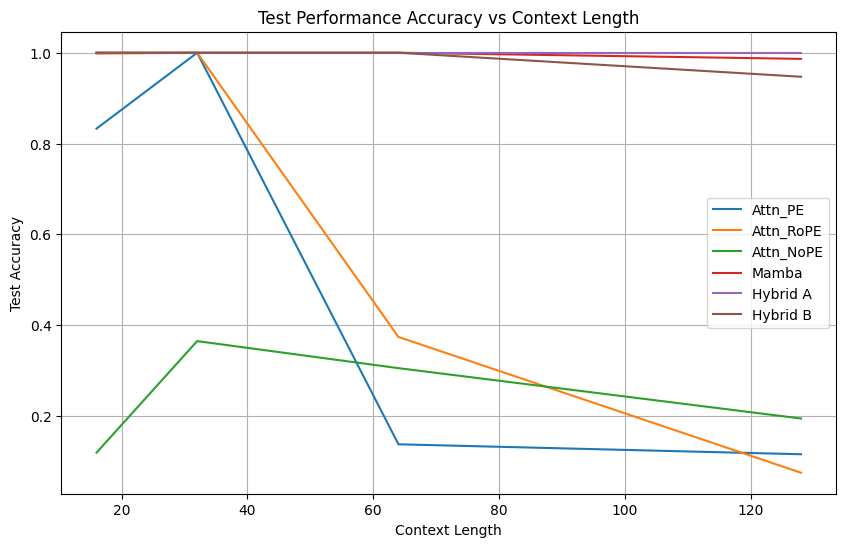

In [14]:
'''
models = [
    BaseNet(len(tokenizer), embed_dim=embed_dim, pos_encoding='LearnedPE', max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device),
    BaseNet(len(tokenizer), embed_dim=embed_dim, pos_encoding='RoPE', max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device),
    BaseNet(len(tokenizer), embed_dim=embed_dim, pos_encoding=None, max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device),
    MixerModel(embed_dim=embed_dim, max_len=n_ctx*4, n_layer=mamba_layers, vocab_size=len(tokenizer)).to(device),
    MixerModelHybrid(embed_dim=embed_dim, max_len=n_ctx*4, n_layer=mamba_layers, vocab_size=len(tokenizer)).to(device),
    MixerModelHybrid(embed_dim=embed_dim, max_len=n_ctx*4, n_layer=mamba_layers+1, vocab_size=len(tokenizer)).to(device)
]
'''
# Corresponding model names for the above-defined models
model_names = {
    0: 'Attn_PE',
    1: 'Attn_RoPE',
    2: 'Attn_NoPE',
    3: 'Mamba',
    4: 'Hybrid A',
    5: 'Hybrid B'
}

# Context lengths to test
context_lengths = [16, 32, 64, 128]

# Placeholder to store results
results = {model_names[index]: [] for index in range(len(models))}

# Loop through each model and test at each context length
for index, model in enumerate(models):
    model_name = model_names[index]
    print(f"Evaluating model: {model_name}")
    for n_ctx in context_lengths:
        dataset = InductionAR(num_examples, tokenizer, 1, n_ctx=n_ctx, seed=seed, train_split=0.01, tau = 1, M = 1)
        train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)[:,-1]
                y_pred = F.softmax(y_pred, dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                correct += (y_pred == y).sum().item()
                total += y.size(0)

        accuracy = correct / total
        results[model_name].append(accuracy)
        print(f"Context length {n_ctx}: Test accuracy = {accuracy}")

# Plotting
plt.figure(figsize=(10, 6))
for name, accuracies in results.items():
    plt.plot(context_lengths, accuracies, label=name)
plt.title('Test Performance Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The above result is graph between test performance and context length. We started with L = 32 for training and we can clearly see that performance of Mamba and Hybrids don't diminish even for larger context lengths. Infact Hybrid A slightly performs better than Mamba and Hybrid B slightly worse. Our of transformer architecture as expected RoPE performs better than learned positional encoding. And even that outperforms no positional encoding which makes sense as positional encoding table is smaller than token embedding table. However, for both transformer architecture the perfomance becomes worse as we go farther into context length. (As expected)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

!pip install nbconvert

!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Recall_M_delay5.ipynb"


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [814 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,748 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,077 kB]
Get:13 http://security.ub